## Exercise 2 - Disparity to depth

Now let us try to convert a disparity map into a depth map. This time we need a pair of stereo images along with known intrinsic and extrinsic parameters. I have included these in the "get started"-script which can be downloaded here.

- Compute the disparity map using the"StereoBM" class. Try to chose sensible values for both the block size and number of disparities. (you can try to inspect foreground objects to make an estimated guess about the number of disparities)
- Reproject the disparity map to 3D using OpenCV's "reprojectImageTo3D(...)"-function. You will need the Q matrix from the "stereoRectify(...)"-function estimated earlier in the script.
- Try to extract the z-values of the resulting 3D points and plot it as a depth map. (hint: you may have to clip the value to a reasonable range to avoid noise. Depth values between 0 and 2000 seems reasonable). Does it make sense? How far away is the potted plant from the camera?
- The translation between the two cameras is currently set to -174.724 mm - what happens if you change it to meters instead? Plot the resulting depth map.


In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

data = "../sword1/"

In [2]:
# Read the images
left = cv2.imread(data + "im0.png", cv2.IMREAD_GRAYSCALE)
right = cv2.imread(data + "im1.png", cv2.IMREAD_GRAYSCALE)

In [3]:
# Prepare the intrinsic parameters of the two cameras
# we assume no lens distortion, i.e. dist coeffs = 0
cameraMatrix1 = np.array([[6872.874, 0, 1605.291], [0, 6872.874, 938.212], [0, 0, 1]])
distCoeffs1 = np.array([0, 0, 0, 0, 0])

cameraMatrix2 = np.array([[6872.874, 0, 1922.709], [0, 6872.874, 938.212], [0, 0, 1]])
distCoeffs2 = np.array([0, 0, 0, 0, 0])

# Prepare the extrinsic parameters
rotationMatrix = np.eye(3)  # we assume no rotation
transVector = np.array([-174.724, 0.0, 0.0])

# Rectify the images using both the intrinsic and extrinsic parameters
# Note: the image pair are already rectified so we do not really need
# to do this but we need to Q matrix to compute depth later on
image_size = left.shape[::-1]
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    cameraMatrix1,
    distCoeffs1,
    cameraMatrix2,
    distCoeffs2,
    image_size,
    rotationMatrix,
    transVector,
)

# Remap the left image based on the resulting rotation R1 and projection matrix P1
leftmapX, leftmapY = cv2.initUndistortRectifyMap(
    cameraMatrix1, distCoeffs1, R1, P1, image_size, cv2.CV_32FC1
)
left_remap = cv2.remap(left, leftmapX, leftmapY, cv2.INTER_LANCZOS4)

# Do the same for the right image
rightmapX, rightmapY = cv2.initUndistortRectifyMap(
    cameraMatrix2, distCoeffs2, R2, P2, image_size, cv2.CV_32FC1
)
right_remap = cv2.remap(right, leftmapX, rightmapY, cv2.INTER_LANCZOS4)

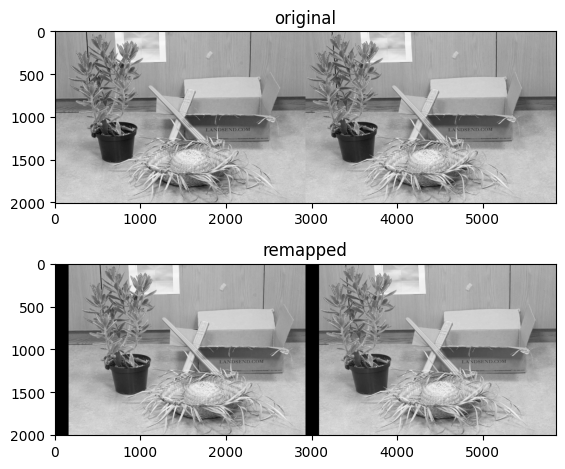

In [4]:
# Let's try to compare the two images before and after rectifying them
# Plot the two original images side-by-side
ax = plt.subplot(211)
ax.set_title("original")
ax.imshow(np.hstack([left, right]), "gray")

# Plot the two remapped images side-by-side
ax = plt.subplot(212)
ax.set_title("remapped")
ax.imshow(np.hstack([left_remap, right_remap]), "gray")
plt.tight_layout()
plt.show()
# They look pretty much identical with the expection of some extra padding
# for the rectifying images. You can use both pair of images for the rest
# of the exercise. It is up to you - both should give valid results.

# You do the rest! Start by calculating the disparity map

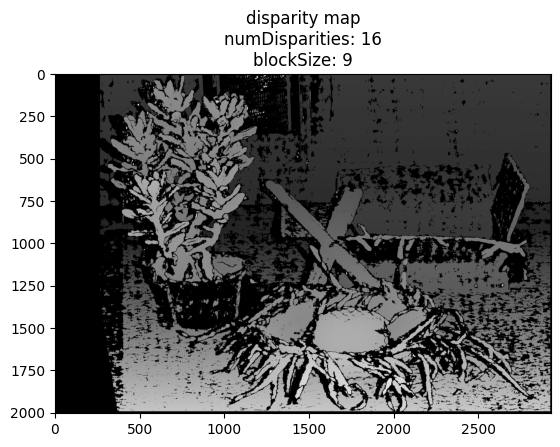

In [8]:
n = 256
m = 21
stereo = cv2.StereoBM.create(numDisparities=n, blockSize=m)
disparity = stereo.compute(left_remap, right_remap)
plt.title(f"disparity map\nnumDisparities: {16}\nblockSize: {9}")
plt.imshow(disparity, "gray")
plt.show()

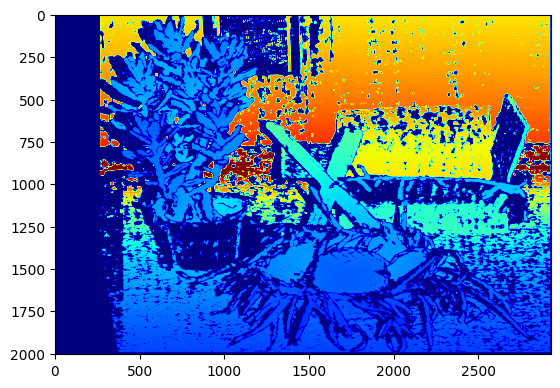

In [9]:
im3d = cv2.reprojectImageTo3D(disparity,Q)

depth_map = im3d[:,:,2].astype(np.float32)

# Clip the resulting z-values to a reasonably range
depth_max = 2000.0
depth_map[depth_map > depth_max] = depth_max
depth_map[depth_map < 0.0] = 0.0

plt.imshow(depth_map,'jet')
plt.show()